In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bower\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Collecting and cleaning the data

In [2]:
df_one = pd.read_csv("datasets/phishing_data_by_type.csv")
df_one = df_one.loc[df_one["Type"] != "False Positives "]

dataset = np.array(df_one["Subject"] + " " + df_one["Text"])
print(len(dataset))

df_two = pd.read_csv("datasets/Phishing_Email.csv")
df_two = df_two.loc[df_two["Email Type"] == "Phishing Email"]

dataset = np.concatenate((dataset, (np.array(df_two["Email Text"]))), axis=0)

print(len(dataset))

120
7448


In [3]:
def clean_text(text):
    text = str(text)
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

data = [clean_text(text) for text in dataset]

## Keyword search to assign attacks to sectors

In [4]:
def keyword_search(sector, keywords, data):
    count = 0
    emails, labels = [], []
    
    # Create a regular expression pattern for matching the keywords
    pattern = "|".join(map(re.escape, keywords))
    pattern = r"\b({})\b".format(pattern)
    
    # Iterate through the email array and search for keywords
    for index, email in enumerate(data, start=1):
        matches = re.findall(pattern, email) 

        if matches:
            # print(f"Email {index} contains the following keywords: {', '.join(matches)}")
            emails.append(email)
            labels.append(sector)
            count += 1
            
    return count, emails, labels

In [5]:
emails = []
labels = []

# Financial Services Sector
finance_keywords = ["banking", "credit card", "wire transfer", "investment", "financial", "atm"]
finance_count, finance_emails, finance_labels = keyword_search("finance", finance_keywords, data)
emails += finance_emails
labels += finance_labels

print("FINANCE:", finance_count)

# Online Services Sector
online_keywords = [ "social media", "privacy policy", "subscription", "online shopping", "online gaming", "tech", "free trial", "product recall", "friend request", "profile update", "order confirmation", "discounts", "discount", "return policy", "exchange policy", "shopping cart", "software updates", "software update", "device", "game", "customer feedback", "gift card"]
# "shipping", "tracking",
online_count, online_emails, online_labels = keyword_search("online", online_keywords, data)
emails += online_emails
labels += online_labels

print("ONLINE:",  online_count)

# Government and Public Sector
gov_keywords = ["government", "job opportunities", "job opportunity", "legal", "nonprofit", "scholarships", "financial aid", "grants", "grant", "social security", "workplace", "campus", "tuition", "transcripts", "transcript", "academic", "student loans", "student loan", "fundraising", "volunteer", "donation", "court", "criminal", "crime", "law", "jury", "payroll", "employee", "vote", "public service", "passport renewal"]
gov_count, gov_emails, gov_labels = keyword_search("gov", gov_keywords, data)
emails += gov_emails
labels += gov_labels

print("GOV:", gov_count)

# Essential Services and Healthcare Sector
health_keywords = ["healthcare", "health", "pharmacy", "covid", "covid-19", "medicine", "medical", "medication", "medicare", "patient", "electricity", "utility", "travel", "airline"]
#"appointment", "appointments",
health_count, health_emails, health_labels = keyword_search("health", health_keywords, data)
emails += health_emails
labels += health_labels

print("HEALTH:", health_count)

FINANCE: 990
ONLINE: 600
GOV: 882
HEALTH: 825


## Graphs and Tables

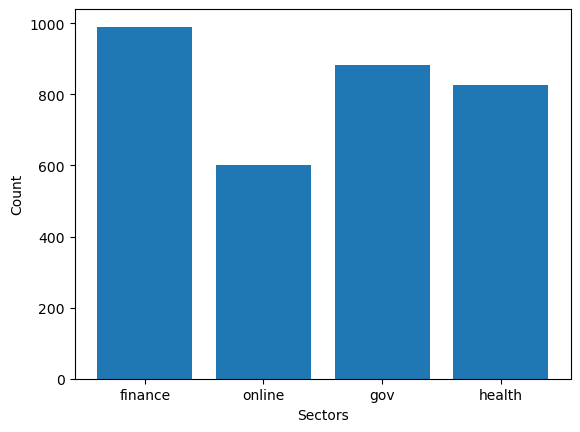

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter(labels)
plt.bar(list(counts.keys()), list(counts.values()))

plt.xlabel('Sectors')
plt.ylabel('Count')

plt.show()

In [7]:
from tabulate import tabulate

max_len = max(len(finance_keywords), len(online_keywords), len(gov_keywords), len(health_keywords))

finance_keywords += [''] * (max_len - len(finance_keywords))
online_keywords += [''] * (max_len - len(online_keywords))
gov_keywords += [''] * (max_len - len(gov_keywords))
health_keywords += [''] * (max_len - len(health_keywords))


table_data = list(map(list, zip(finance_keywords, online_keywords, gov_keywords, health_keywords)))

col_labels = ["Financial Sector", "Online Services Sector", "Government Sector", "Healthcare Sector"]
table = tabulate(table_data, headers=col_labels, tablefmt="fancy_grid", numalign="center")

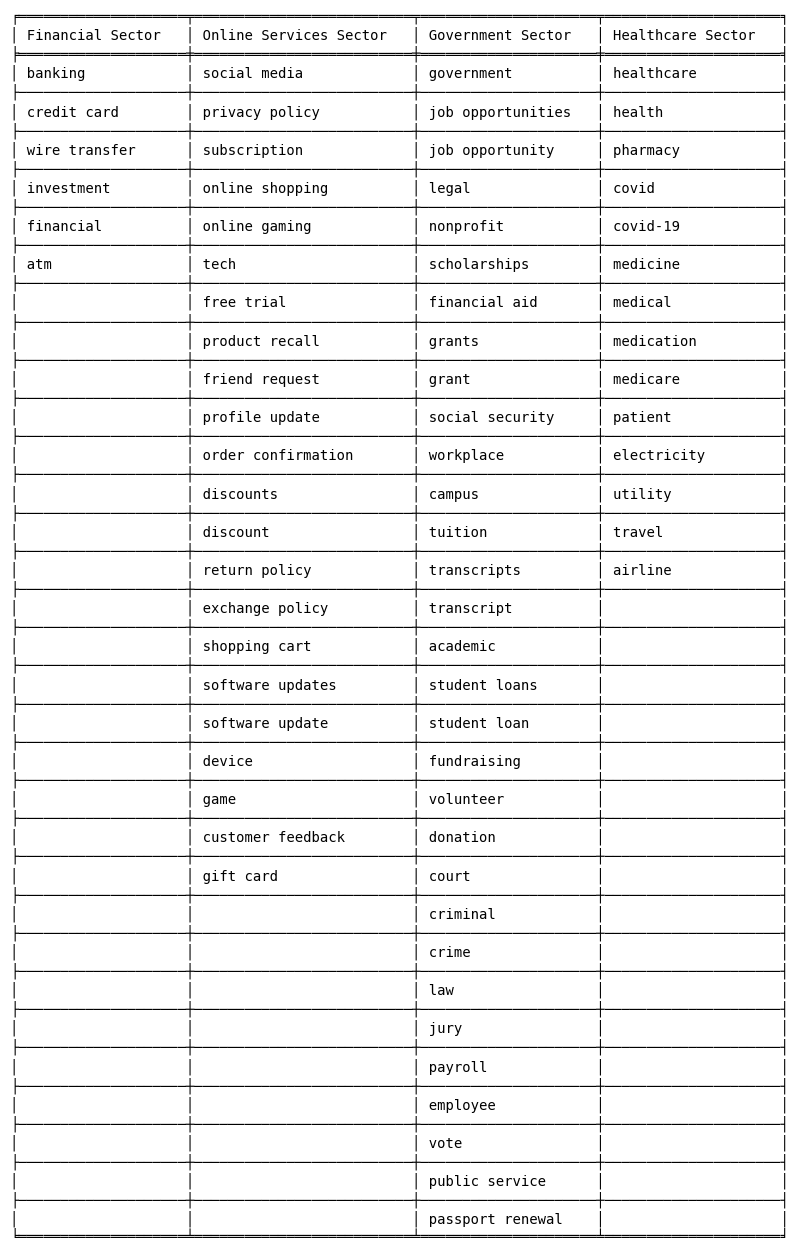

In [8]:
fig, ax = plt.subplots()

ax.axis("off")
ax.annotate(table, xy=(0, 0), fontsize=10, family="monospace")

plt.show()

## K-Means Clustering

In [14]:
# Clustering
X = emails
y = labels

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Create a TF-IDF vectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

n_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
X_clusters = kmeans.fit_predict(X_tfidf)

# Create an array to store the total TF-IDF values for each word in each cluster
cluster_word_tfidf_sums = []

for cluster_id in range(n_clusters):
    # Select the emails that belong to the current cluster
    cluster_indices = [i for i, cluster in enumerate(X_clusters) if cluster == cluster_id]

    # Create a submatrix containing only the emails in this cluster
    cluster_submatrix = X_tfidf[cluster_indices]

    # Sum the TF-IDF values for each word across all emails in the cluster
    word_tfidf_sums = np.array(cluster_submatrix.sum(axis=0))[0]

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Create a list of (word, total TF-IDF) pairs
    cluster_word_tfidf_sums.append(list(zip(feature_names, word_tfidf_sums)))

# Print the most common words for each cluster
N = 10
for cluster_id, word_tfidf_sums in enumerate(cluster_word_tfidf_sums):
    print(f"Cluster {cluster_id} - Most common words:")
    sorted_words = sorted(word_tfidf_sums, key=lambda x: x[1], reverse=True)
    for word, tfidf_sum in sorted_words[:N]:
        print(f"{word}: {tfidf_sum:.3f}")

Cluster 0 - Most common words:
statements: 61.826
company: 53.331
securities: 33.355
wysak: 28.027
stock: 27.738
report: 27.005
may: 25.918
information: 25.107
within: 24.841
gas: 23.807
Cluster 1 - Most common words:
account: 31.845
transaction: 29.826
bank: 27.736
money: 27.122
kin: 21.257
fund: 21.111
funds: 20.431
transfer: 18.488
country: 18.406
us: 17.215
Cluster 2 - Most common words:
email: 47.921
free: 45.629
click: 41.307
credit: 38.891
get: 37.987
please: 35.241
online: 35.240
com: 33.769
http: 32.590
information: 32.504
Cluster 3 - Most common words:
report: 38.305
money: 23.938
people: 23.820
program: 22.803
grants: 21.491
000: 18.882
make: 18.116
name: 17.620
orders: 17.472
order: 17.148
